We will begin with a few imports that we would need while implementing Naive Bayes

In [0]:
import numpy as np  
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
nltk.download('stopwords')
%matplotlib inline

#Step 1 Collecting Data

We will use the collection of SMS messages, which was put together on the same Example " filtering mobile phone spam with the Naive Bayes algorithm" (See Ch. 4 of Machine Learning with R - Second Edition, in pp. 103-124), using the same dataset (can be found at https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/sms_spam.csv) 

#Step 2 Exploring and preparing the data

##Processing text data for analysis

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
url = 'gdrive/My Drive/ALY_6020/sms_spam.csv'
sms_raw_df = pd.read_csv(url)
sms_raw_df.head (10)

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Dataset structure is simple. It contains two columns — one for the type “spam/ham” and another for the text of the message.


In [0]:
sms_raw_df['type'].value_counts()

ham     4827
spam     747
Name: type, dtype: int64

It contains 4827 records of different messages together with 747 spam messages.


In [0]:
"""
Factorize ham -> 0, spam -> 1
"""
sms_raw_df['type'], _ = pd.factorize(mails['type'], sort=True)
sms_raw_df

,type,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...
5570,0,Will ü b going to esplanade fr home?
5571,0,"Pity, * was in mood for that. So...any other s..."
5572,0,The guy did some bitching but I acted like i'd...


In [0]:
"""
Clean up and split to words
"""
def clean_up_text(text):
  # to lower case
  text = text.lower()
  # remove number
  text = text.translate(str.maketrans('', '', '0123456789'))
  # remove punctuantion
  text = text.translate(str.maketrans('', '', string.punctuation))
  
  # remove white space
  text = re.sub(' +', ' ', text)

  words = text.split()

  # remove stop words
  stop_words_from_book = ['to', 'and', 'but', 'or']
  stop_words = stopwords.words('english') + stop_words_from_book
  words = [w for w in words if w not in stop_words]
  
  return words
corpus_clean_df = sms_raw_df.copy()
corpus_clean_df['text'] = corpus_clean_df['text'].apply(clean_up_text)
corpus_clean_df

,type,text
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t..."
...,...,...
5569,1,"[nd, time, tried, contact, u, u, £, pound, pri..."
5570,0,"[ü, b, going, esplanade, fr, home]"
5571,0,"[pity, mood, soany, suggestions]"
5572,0,"[guy, bitching, acted, like, id, interested, b..."


In [0]:
"""
Create sparse matrix
"""
# all words
words = set()
for i in range(len(corpus_clean_df)):
  for w in corpus_clean_df['text'][i]:
    words.add(w)
len(words)

# create matrix
sms_dtm = {}
for w in words:
  sms_dtm[w] = [0] * len(mails)
for i in range(len(corpus_clean_df)):
  for w in corpus_clean_df['text'][i]:
    sms_dtm[w][i] = sms_dtm[w][i] + 1
sms_dtm_df = pd.DataFrame(sms_dtm)

In [0]:
sms_dtm_df

,ogunrinde,cough,itriedtell,r,soonxxx,stars,vary,latelyxxx,strongly,birthday,mode,spider,bookedthe,booked,bull,weighed,telephonic,bcoz,youany,iphone,themes,trauma,clas,winaweek,rajnikant,cheat,broadband,calls£minmobsmore,page,dreamz,ques,gamestar,inconvenience,clear,connect,nookii,perspective,flip,yeshere,apparently,...,poor,rich,hillsborough,saw,clocks,tome,personality,sexy,back,msgsubscription,comb,rats,meetgreet,itjust,manageable,otherwise,weird,ibored,sister,drinkpa,lunch,overtime,reppurcussions,sweetie,ppermesssubscription,definite,blueu,flatter,woohoo,wasn‘t,wondarfull,aathiwhere,buffy,guy,annoncement,youwhen,outside,ability,ubandu,oranges
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Creating training and text datasets

##Train - Test Split

To test our model we should split the data into train dataset and test dataset. We shall use the train dataset t0 train the model and then it will be tested on the test dataset. We shall use 75% of the dataset as train dataset and the rest as test dataset. Selection of this 75% of the data is uniformly random.


In [0]:
"""
Splitting raw data
"""
sms_raw_train_df = sms_raw_df[:4169]
sms_raw_test_df = sms_raw_df[4169:]
sms_raw_test_df.reset_index(inplace = True)
sms_raw_test_df.drop(['index'], axis = 1, inplace = True)
sms_raw_test_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,type,text
0,1,Congrats! Nokia 3650 video camera phone is you...
1,0,Haven't heard anything and he's not answering ...
2,0,"Mmmmmm ... I love you,so much, Ahmad ... I can..."
3,0,Pls what's the full name of joke's school cos ...
4,0,"Sorry, I'll call later"
...,...,...
1400,1,This is the 2nd time we have tried 2 contact u...
1401,0,Will ü b going to esplanade fr home?
1402,0,"Pity, * was in mood for that. So...any other s..."
1403,0,The guy did some bitching but I acted like i'd...


In [0]:
"""
Splitting document-term matrix
"""
sms_dtm_train_df = sms_dtm_df[:4169]
sms_dtm_test_df = sms_dtm_df[4169:]
sms_dtm_test_df.reset_index(inplace = True)
sms_dtm_test_df.drop(['index'], axis = 1, inplace = True)
sms_dtm_test_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ogunrinde,cough,itriedtell,r,soonxxx,stars,vary,latelyxxx,strongly,birthday,mode,spider,bookedthe,booked,bull,weighed,telephonic,bcoz,youany,iphone,themes,trauma,clas,winaweek,rajnikant,cheat,broadband,calls£minmobsmore,page,dreamz,ques,gamestar,inconvenience,clear,connect,nookii,perspective,flip,yeshere,apparently,...,poor,rich,hillsborough,saw,clocks,tome,personality,sexy,back,msgsubscription,comb,rats,meetgreet,itjust,manageable,otherwise,weird,ibored,sister,drinkpa,lunch,overtime,reppurcussions,sweetie,ppermesssubscription,definite,blueu,flatter,woohoo,wasn‘t,wondarfull,aathiwhere,buffy,guy,annoncement,youwhen,outside,ability,ubandu,oranges
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
"""
Splitting clean corpus
"""
sms_corpus_train_df = corpus_clean_df[:4169]
sms_corpus_test_df = corpus_clean_df[4169:]
sms_corpus_test_df.reset_index(inplace = True)
sms_corpus_test_df.drop(['index'], axis = 1, inplace = True)
sms_corpus_train_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,type,text
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t..."
...,...,...
4164,0,"[told, coming, wednesday]"
4165,0,"[ok, called, mom, instead, fun]"
4166,1,"[dear, voucher, holder, claim, weeks, offer, p..."
4167,0,"[well, im, desperate, ill, call, armand]"


In [0]:
sms_raw_train_df['type'].value_counts()

0    3605
1     564
Name: type, dtype: int64

In [0]:
sms_raw_test_df['type'].value_counts()

0    1222
1     183
Name: type, dtype: int64

#Visualizing text data - word clouds

Now we can see which are the most repeated words in the spam messages. We are going to use WordCloud library for this purpose.



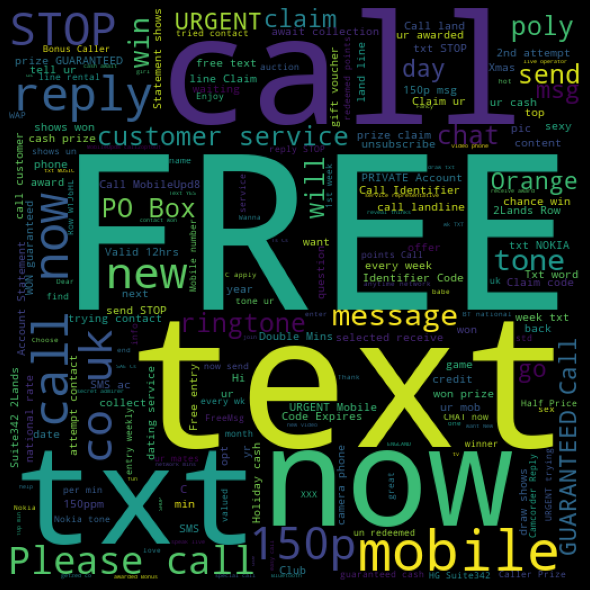

In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

spam_words = ' '.join(list(sms_raw_df[sms_raw_df['type'] == 1]['text']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

It is clear that these messages mostly contain the words like ‘FREE’, ‘call’, ‘text’, ‘ringtone’, ‘mobile’ etc.


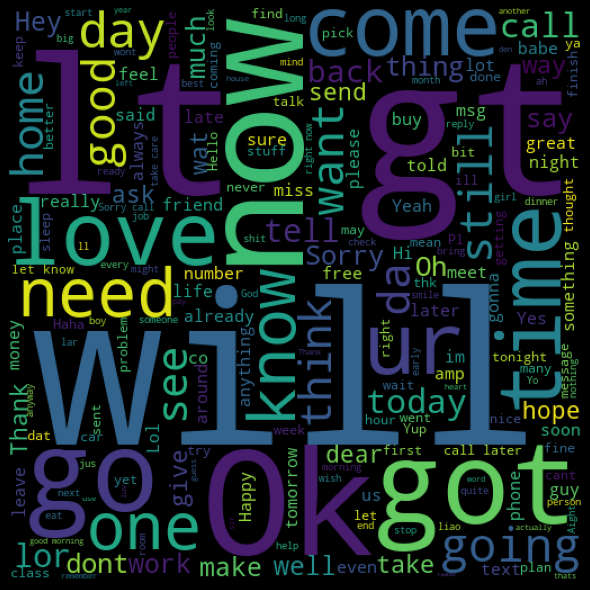

In [0]:
ham_words = ' '.join(list(sms_raw_df[sms_raw_df['type'] == 0]['text']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Similarly the wordcloud of ham messages mostly contain of the words: 'Ok', 'will', 'time', etc.


#Data Preparation - Creating indicator feature for frequent words

In [0]:
"""
Find frequent term (appear >= 5 times)
"""
sms_dict = []
for word in sms_dtm_train_df:
  freq = sms_dtm_train_df[word].sum()
  if freq >= 5:
    sms_dict.append(word)

In [0]:
"""
Limit train and test matrixes to only frequent words
"""
all_words = sms_dtm_df.columns.to_list()
remove_words = [w for w in all_words if w not in sms_dict]
sms_train_df = sms_dtm_train_df.drop(remove_words, axis=1)
sms_test_df = sms_dtm_test_df.drop(remove_words, axis=1)

sms_test_df

,r,vary,birthday,mode,booked,bcoz,page,reason,voice,expecting,spoke,bus,email,orange,wont,den,wats,apply,naked,ipod,project,chance,smoke,notice,different,cd,goodmorning,die,working,texts,advance,okay,wen,ex,cashin,club,comes,weather,checking,pound,...,shows,space,thought,sms,feeling,cr,unlimited,youve,shuhui,tonight,happy,crave,kate,trust,fine,hiya,service,camera,net,let,asked,rreveal,howz,weekend,kick,finally,unsubscribe,weight,free,meh,whos,poor,saw,sexy,back,otherwise,sister,lunch,guy,outside
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [0]:
"""
Convert counts to Yes (1)/No (0)
"""
def convert_count(x):
  return 1 if x > 0 else 0

sms_train_df = sms_train_df.applymap(convert_count)
sms_test_df = sms_test_df.applymap(convert_count)
sms_test_df

,r,vary,birthday,mode,booked,bcoz,page,reason,voice,expecting,spoke,bus,email,orange,wont,den,wats,apply,naked,ipod,project,chance,smoke,notice,different,cd,goodmorning,die,working,texts,advance,okay,wen,ex,cashin,club,comes,weather,checking,pound,...,shows,space,thought,sms,feeling,cr,unlimited,youve,shuhui,tonight,happy,crave,kate,trust,fine,hiya,service,camera,net,let,asked,rreveal,howz,weekend,kick,finally,unsubscribe,weight,free,meh,whos,poor,saw,sexy,back,otherwise,sister,lunch,guy,outside
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


#Step 3 Training a model on the data

In [0]:
"""
Train models
"""
# splitting spam and ham rows
spam_indexes = []
ham_indexes = []
for i in range(len(sms_raw_train_df)):
  if sms_raw_train_df['type'][i] == 0:
    ham_indexes.append(i)
  else:
    spam_indexes.append(i)

# to separate data frame
sms_spam_train_df = sms_train_df[sms_train_df.index.isin(spam_indexes)]
sms_ham_train_df = sms_train_df[sms_train_df.index.isin(ham_indexes)]

# then calculate probabilities
ham_with_word_prob = {}                                # P(x = has W | C = Ham)
ham_no_word_prob = {}                                  # P(x = no W | C = Ham)
spam_with_word_prob = {}                               # P(x = has W | C = Spam)
spam_no_word_prob = {}                                 # P(x = no W | C = Spam)

ham_prob = len(sms_ham_train_df) / len(sms_train_df)   # P(C = Spam)
spam_prob = len(sms_spam_train_df) / len(sms_train_df) # P(C = Ham)

for word in sms_ham_train_df:
  count = sms_ham_train_df[word].sum()
  ham_with_word_prob[word] = count / len(sms_ham_train_df)
  ham_no_word_prob[word] = 1 - ham_with_word_prob[word]
  
for word in sms_spam_train_df:
  count = sms_spam_train_df[word].sum()
  spam_with_word_prob[word] = count / len(sms_spam_train_df)
  spam_no_word_prob[word] = 1 - spam_with_word_prob[word]

In [0]:
"""
Predict
"""
def predict(sms_test_in):
  r = []
  for i in range(len(sms_test_in)):
    p_ham_prob = ham_prob
    p_spam_prob = spam_prob
    for word in sms_test_in:
      if sms_test_in[word][i] == 1:
        p_ham_prob = p_ham_prob * ham_with_word_prob[word]
        p_spam_prob = p_spam_prob * spam_with_word_prob[word]
      else:
        p_ham_prob = p_ham_prob * ham_no_word_prob[word]
        p_spam_prob = p_spam_prob * spam_no_word_prob[word]
    #print ('i = ', i, 'p_s = ', p_spam_prob, 'p_h = ', p_ham_prob)
    r = r + [1 if p_spam_prob > p_ham_prob else 0]
  return r


# Step 4. Evaluating model performance

In [0]:
"""
Util funtion to evaluate
"""
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    print(pd.DataFrame({
        "": ["predicted spam", "predicted ham", "column total"],
        "actual spam": [true_pos, false_neg, true_pos + false_neg],
        "actual ham": [false_pos, true_neg, false_pos + true_neg],
        "row total": [true_pos + false_pos, false_neg + true_neg, len(labels)]
    }))



In [0]:
"""
Evaluate
"""
metrics( sms_raw_test_df['type'].tolist(), predict(sms_test_df) )

                   actual spam  actual ham  row total
0  predicted spam          152           2        154
1   predicted ham           31        1220       1251
2    column total          183        1222       1405


# Step 5. Improving model performance

In [0]:
"""
Improve using laplace estimator
"""

laplace_estimator = 1

def get_ham_p(p):
  return p if p > 0 else laplace_estimator / len(sms_ham_train_df)

def get_spam_p(p):
  return p if p > 0 else laplace_estimator / len(sms_spam_train_df)

def predict_2(sms_test_df):
  r = []
  for i in range(len(sms_test_df)):
    p_ham_prob = ham_prob
    p_spam_prob = spam_prob
    for word in sms_test_df:
      if sms_test_df[word][i] == 1:
        p_ham_prob = p_ham_prob * get_ham_p(ham_with_word_prob[word])
        p_spam_prob = p_spam_prob * get_spam_p(spam_with_word_prob[word])
      else:
        p_ham_prob = p_ham_prob * get_ham_p(ham_no_word_prob[word])
        p_spam_prob = p_spam_prob * get_spam_p(spam_no_word_prob[word])
    r = r + [1 if p_spam_prob > p_ham_prob else 0]
  return r

In [0]:
"""
Evaluate the improvement
"""
metrics( sms_raw_test_df['type'].tolist(), predict_2(sms_test_df) )


                   actual spam  actual ham  row total
0  predicted spam          165           6        171
1   predicted ham           18        1216       1234
2    column total          183        1222       1405
